In [142]:
import pandas as pd
from blp.bdx import bdh,bdp,bds
import numpy as np
import utilities.misc as um
import utilities.mathematics as umath
import utilities.constants as uc
import utilities.display as ud
from datetime import datetime
from pykalman import KalmanFilter
from utilities.mathematics import rolling_regression
import plotly.express as px

In [75]:
# get some data
tickers=['2899 HK Equity','HSCEI Index','XAU Curncy','USGG10YR Index','CNY Curncy']
fields=['px_last']
start=datetime(2006,12,31)
end=um.yesterday_date()
data=bdh(tickers,fields,start,end,)['px_last'].unstack().T.fillna(method='ffill')
ret=data.pct_change(5)

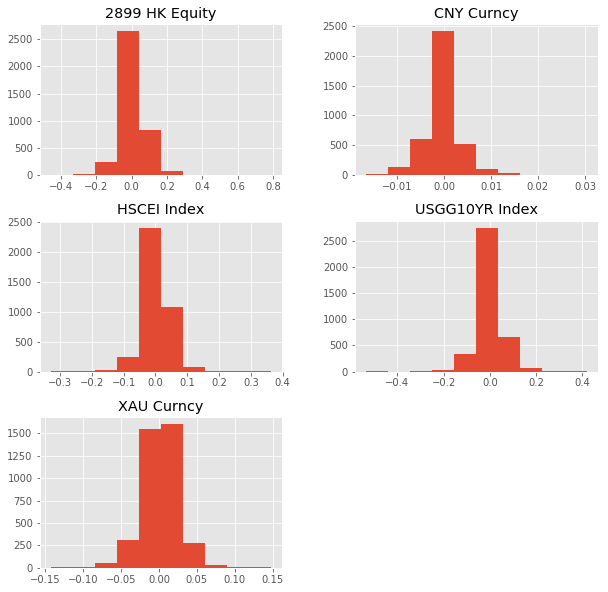

In [76]:
fig_res=ret.hist(figsize=(10,10))

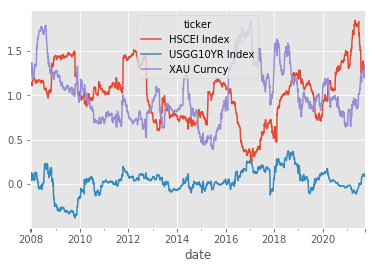

In [77]:
# do the regression
reg_res=umath.rolling_regression(ret,'2899 HK Equity',['HSCEI Index','USGG10YR Index','XAU Curncy'],252)
reg_res.beta.plot()

In [78]:
# Kalman filter regression
xs=['HSCEI Index','USGG10YR Index','XAU Curncy']
collector=[]
for x in xs:
    res_i=umath.KF_beta(ret.dropna(),'2899 HK Equity',x,add_ols=[True,252])
    res_i['x']=x
    collector.append(res_i)
beta_comp=pd.concat(collector,axis=0)

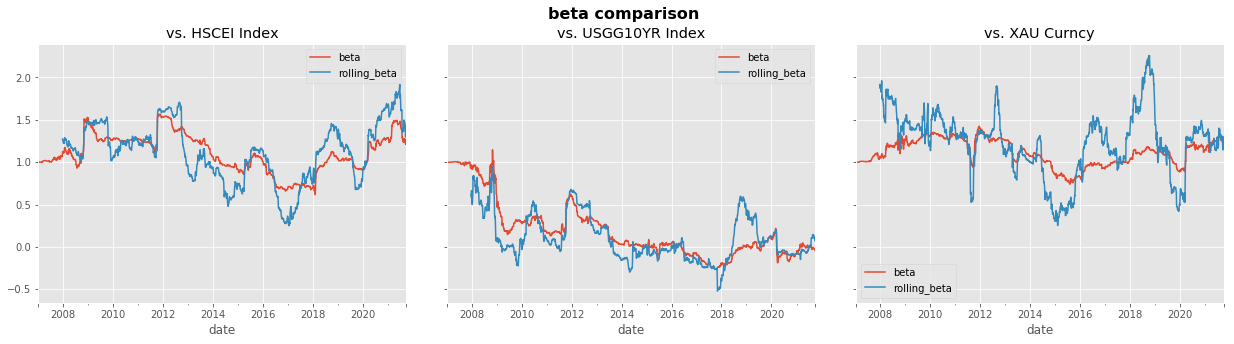

In [79]:
fig,axes=ud.easy_plot_quick_subplots((1,3),'beta comparison',sharey=True)
for i,x in enumerate(xs):
    to_plot=beta_comp[beta_comp['x']==x]#.dropna()
    to_plot[['beta','rolling_beta']].plot(ax=axes[i],title='vs. %s' % (x))

In [171]:
# try Kalman filter with multiple inputs
def KF_betas(df,y,xs,add_ols=[True,504],
            hp_isc=1e-5, # initial_state_covariance
            hp_tc=1e-5, # transition_covariance
            hp_oc=1e-3, # observation_covariance. Smaller --> more responsive, very large --> flat line
            auto_estimate_initial_beta=[False,0.1] # use a given proportion of the initial data to estimate initial beta using regression. 
                                                     # Not recommended unless the initial estimate happens to be close to the long time mean
            ):
    '''
    Multivariate KF-based beta estimation enabled
    The parameter auto_estimate_initial_beta is for fun, better not use it
    For initial level different from ols, the KF will adjust automatically based on the hyper parameters. If it looks too bad we can include longer history
    '''
    if auto_estimate_initial_beta[0]:
        proportion=auto_estimate_initial_beta[1]
        df=df.iloc[int(len(df)*proportion)+1:]
        df_est=df.iloc[:int(len(df)*proportion)]
        reg_est=umath.rolling_regression(df_est,y,xs,int(len(df)*proportion)-1).beta.iloc[-1][xs]
    
    data_to_use=df.copy()
    obs_input=data_to_use[xs].copy()
    obs_input['intercept']=1 # indication of intercept, not level of intercept
    obs_input=[x.reshape(1,len(xs)+1) for x in obs_input.values]

    kf = KalmanFilter(

        initial_state_mean=np.array([1]* len(xs)+[0]) if not auto_estimate_initial_beta[0] else np.array(reg_est.values.tolist()+[0]), # initial betas are 1 and initial intercept is 0
        initial_state_covariance=hp_isc*np.eye(len(xs)+1),
        transition_matrices=np.eye(len(xs)+1),
        transition_covariance=hp_tc* np.eye(len(xs)+1),
        observation_matrices=obs_input,
        observation_covariance=hp_oc,# The larger the oversevation error is, the more cautious the model is to update state
    )

    state_means, state_covs = kf.filter(data_to_use[y].values)
    res=pd.DataFrame(index=data_to_use.index,columns=xs+['intercept'],data=state_means)
    res.columns.name='ticker'

    if add_ols[0]:
        rolling_reg_res=rolling_regression(data_to_use,y,xs,add_ols[1])
        rolling_beta=rolling_reg_res.beta
        rolling_beta['intercept']=rolling_reg_res.alpha
        # we create multil columns for easier comparison
        rolling_beta=rolling_beta.stack().rename('value').to_frame()
        rolling_beta['type']='RR'

        res=res.stack().rename('value').to_frame()
        res['type']='KF'
        res=pd.concat([res,rolling_beta],axis=0).reset_index().set_index(['date','ticker','type'])['value'].unstack().unstack()
        
    return res


# We can eyeball the hyper parameter by comparing against the 2-year weekly return rolling regression.

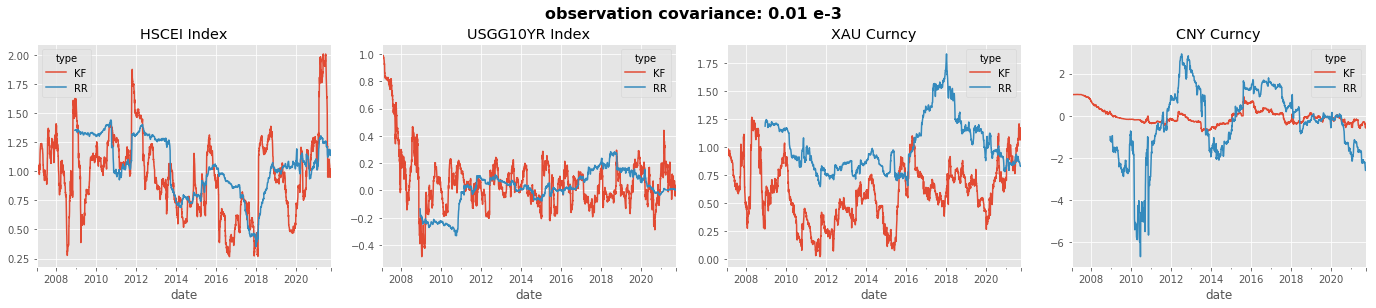

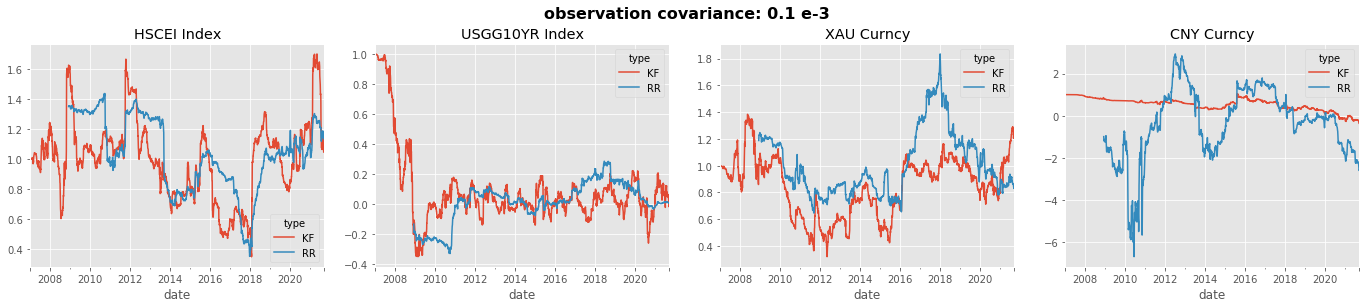

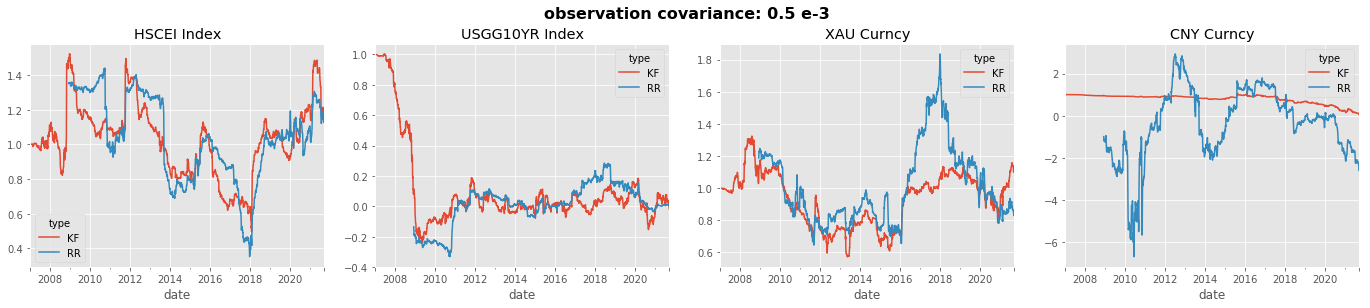

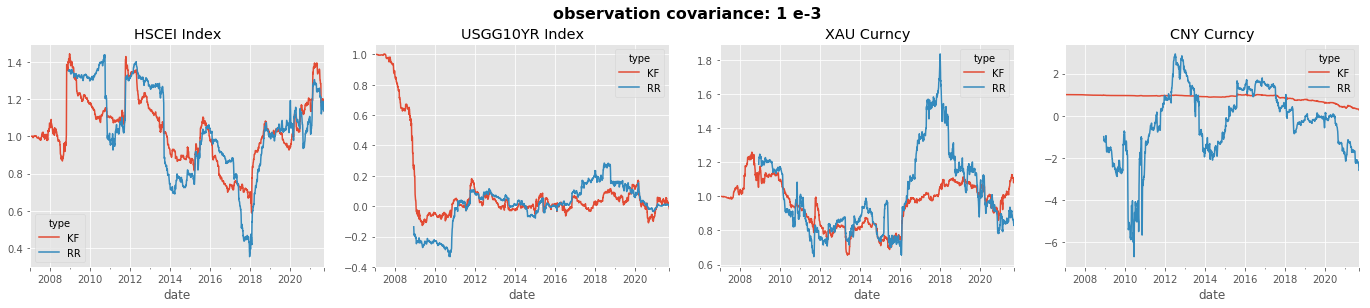

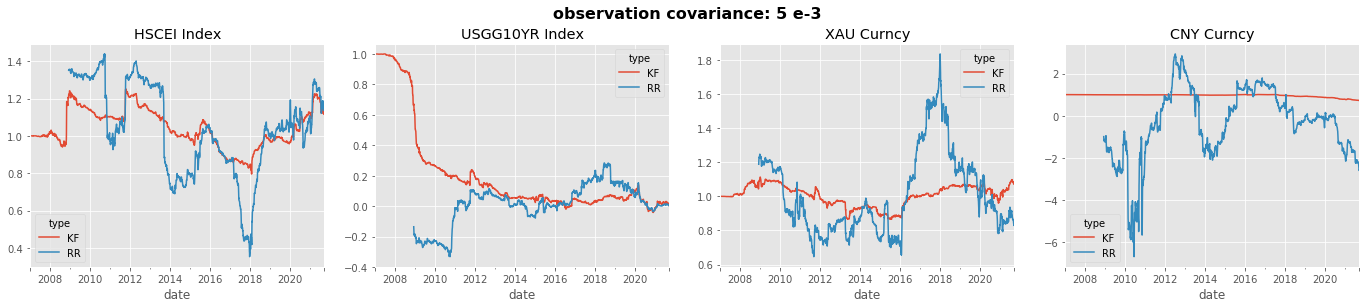

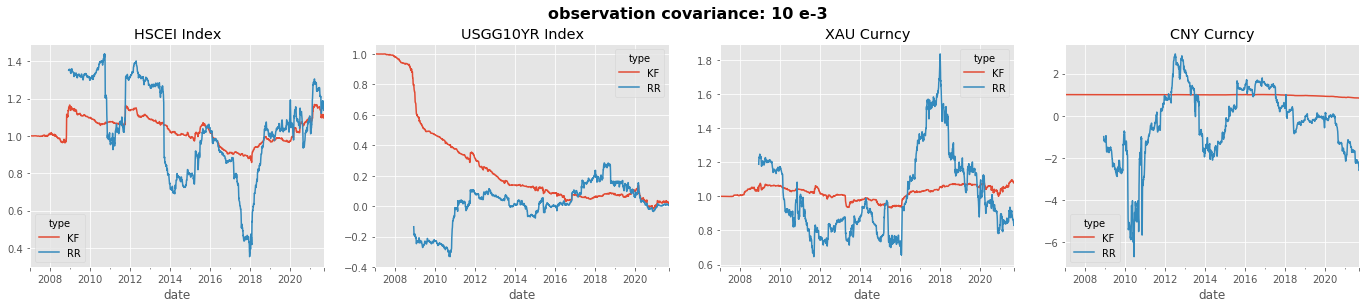

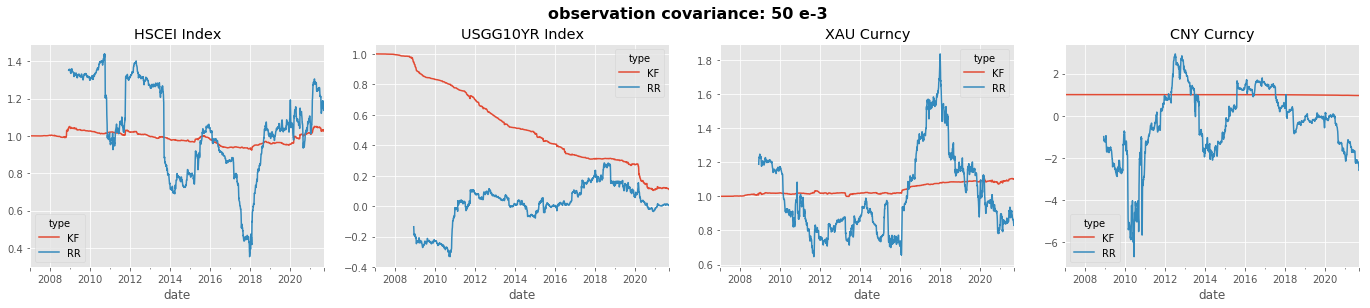

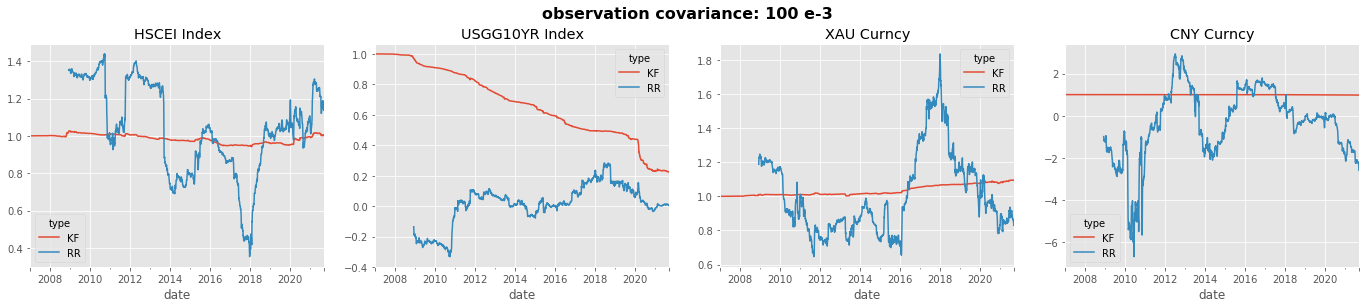

In [172]:
y='2899 HK Equity'
xs=['HSCEI Index','USGG10YR Index','XAU Curncy','CNY Curncy']

hp_oc_all=[0.01,0.1,0.5,1,5,10,50,100]
collector=[]
for hp_oc in hp_oc_all:
    to_check=KF_betas(ret.dropna(),y,xs,hp_oc=hp_oc*1e-3).swaplevel(1,0,1).sort_index(axis=1)
    to_collect=to_check.swaplevel(1,0,1)['KF'].stack().rename('beta').to_frame()
    to_collect['hp']=hp_oc
    collector.append(to_collect)
    fig,axes=ud.easy_plot_quick_subplots((1,4),'observation covariance: %s e-3' % (hp_oc),sharey=False)
    for i,x in enumerate(xs):
        to_check[x].plot(ax=axes[i],title=x)
hp_comp=pd.concat(collector)

In [173]:
fig=px.line(hp_comp.swaplevel(1,0,0).loc['HSCEI Index'].reset_index(),x='date',y='beta',color='hp')
fig.show()